# Algoritmos Variacionales Cuánticos para Problema del Vector Más Corto

## Autor: Zhengkai Zhu

En el siguiente notebook se va a presentar la implementación del algoritmo de VQE para encontrar el estado de mínima energía de un Hamiltoniano codificado para el Problema del Vector Más Corto.\
Se mostrará la implementación para dimension 2.

In [ ]:
#!pip install qiskit[visualization]

In [ ]:
#!pip install qiskit_aer


In [ ]:
#!pip install qiskit_optimization

In [ ]:
#!pip install qiskit_ibm_runtime

In [6]:
from qiskit.circuit.library import EfficientSU2, TwoLocal

from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.converters import InequalityToEquality
from qiskit_optimization.converters import LinearInequalityToPenalty
from qiskit_optimization.converters import IntegerToBinary
from qiskit_optimization.translators import from_docplex_mp

from qiskit.visualization import plot_histogram

import numpy as np
import matplotlib.pyplot as plt
import sympy as sp


from docplex.mp.model import Model

from scipy.optimize import minimize

import warnings

warnings.filterwarnings("ignore")

## 1. Introducción

Queremos resolver el Problema del Vector Más Corto utilizando algoritmos variacionales, específicamente VQE.\
Para ello tenemos que definir la función que queremos minimizar. 

Dado una base $B = [b_1, ..., b_n] \in \mathbb{R}^{d \times n}$ siendo $B$ una matriz columna, un retículo o lattice es el siguiente conjunto discreto de puntos/vectores: $$\mathcal{L}(B) = \{Bx: x \in \mathbb{Z}^n\} = \{\sum_{i} x_i b_i: x_i \in \mathbb{Z}\}$$
Es el conjunto de todas las combinaciones lineales con enteros de los vectores de la base $B$.

Entonces, de ese conjunto de vectores queremos encontrar el vector con el módulo respecto de la norma Euclideana mínima.
$$\lambda_1(\mathcal{L}(B)) = min\{\lVert y\rVert : y \in \mathcal{L}(B) \}$$
Queremos encontrar $v \in \mathcal{L}(B)$ tal que $\lVert v \rVert = \lambda_1(\mathcal{L}(B))$. 

Voy a tratar con matrices $B$ cuadradas, es decir, $B \in \mathbb{R}^{n \times n}$.\
La optimización que queremos hacer es la siguiente (ya en su forma cuadrática sin restricciones):
$$\lambda_1(\mathbb{L}(B))^2 = min\{\lVert y\rVert^2 : y \in \mathbb{L}(B) \}$$
$$\lambda_1(\mathbb{L}(B))^2 = min\{\lVert Bx\rVert^2 : x \in \mathbb{Z}^n \}$$
$$\lambda_1(\mathbb{L}(B))^2 = min\{x^TB^TBx : x \in \mathbb{Z}^n  \}$$

Si $G = B^TB$.

$$min\{(x_1,x_2,...,x_n)G(x_1,x_2,...,x_n)^T : x_i \in \mathbb{Z}^n, i= 1...n, (x_1,x_2,...,x_n) \ne 0 \}$$

$$\min_{x \in \mathbb{Z}^n\backslash\{0\}}{\sum_{i = 1}^n x_i G_{ii} + 2\sum_{1 \le i\le j \le n} x_i x_j G_{ij}}$$


En nuestro caso:\
$x \in \mathbb{Z}^n$ representa el vector de las variables Enteras que representa la combinación lineal de los vectores la base $B$ para obtener el vector de longitud mínima.

Restricciones:\
$x \ne 0$ es decir, no puede ser el vector nulo.

Además, necesitamos una cota para todas las $n$ variables para así tener un número de qubits finito.\
En este notebook voy a tratar con espacios de dimensión muy pequeñas, por tanto voy a utilizar las cotas específicas que podemos obtener del $Teorema\ de\ Minkowski$ y no la $Heurísitca\ Gaussiana$.

El $Teorema\ de\ Minkowski$ proporciona la siguiente cota superior para la longitud del vector más corto:
$$\lambda_1 \le \frac{2}{vol(\mathbb{S}^n)^{1/n}}det(\mathcal{L}(B))^{1/n}$$

$vol(\mathbb{S}^n)$: Volumen de la n-esfera de una unidad de radio.

$det(\mathcal{L}(B))$: Volumen del paralelepípedo formado por los vectores de la base (es la misma sin importar qué base escojas para el retículo).

Volumenes de las esferas:
- Dimensión 2: $\pi$
- Dimensión 3: $\frac{4 \pi}{3}$

Antes vamos a definir el retículo dual que nos permitirá ofrecer una cota personalizada para cada variable dado una cota A.

El retículo dual de $\mathcal{L}(B)$ se denota $\widehat{\mathcal{L}(B)}$:
$$\widehat{\mathcal{L}(B)} = \{w \in span(B): \langle w, x \rangle = z, \forall x \in \mathcal{L}(B), z \in \mathbb{Z}\}$$

Es decir son todos los vectores del espacio vectorial generado por $B$ tal que su producto vectorial con los vectores del retículo sea un entero. 

$\hat{B} = [\hat{b_1}, ..., \hat{b_n}]$ es la base dual de $B$ donde para matrices cuadradas se cumple que :

$$\hat{B} = B^{-T}$$

Ahora dado una cota $A$ en el cual vamos a centrar nuestro espacio de búsqueda:

Si $\lVert Bx \rVert \le A$ $\Rightarrow$ $x_i \le A \lVert \hat{b_i} \rVert$

## Dimensión 2

### Caso 1

In [163]:
n = 2

Para empezar la prueba he implementado el algoritmo para resolver un caso sencillo de dimensión 2.

La base de vectores que declarado es la siguiente: $B = [(1, 1), (2, -1)]$. Entonces la matrix $B$ como matriz columna es:

$$ B = 
\begin{pmatrix}
    1 & 2 \\
    1 & -1
\end{pmatrix}
$$

En este caso los vectores más cortos son en principio son los de la base. Específicamente el más corto es el vector $(1, 1)$ que tiene módulo $\lVert (1, 1) \rVert = \sqrt(2)$.
Luego el segundo es $(2, -1)$ con módulo $\lVert (2, -1) \rVert = \sqrt(5)$

In [164]:
B = np.array([[1, 2], 
              [1, -1]])
display(sp.Matrix(B))

Bt = B.transpose()
display(sp.Matrix(Bt))

B_inv = np.linalg.inv(B)
display(B_inv)

B_dual = B_inv.transpose() #Es una matriz columna
display(B_dual)

Matrix([
[1,  2],
[1, -1]])

Matrix([
[1,  1],
[2, -1]])

array([[ 0.33333333,  0.66666667],
       [ 0.33333333, -0.33333333]])

array([[ 0.33333333,  0.33333333],
       [ 0.66666667, -0.33333333]])

Calculo aquí el vector G que me permitirá calcular el módulo.

$$G = 
\begin{pmatrix}
    2 & 1 \\
    1 & 5
\end{pmatrix}
$$

In [165]:
G = Bt @ B

display(sp.Matrix(G))

Matrix([
[2, 1],
[1, 5]])

In [166]:
vol = int(abs( np.linalg.det(B)))
print(vol)

circulo = np.pi 

A = (2/np.sqrt(circulo)) * np.sqrt(vol) #Cota de Minkowski

print(A)

cotas = np.array([A * (np.linalg.norm(B_dual.transpose()[i])) for i in range (n)]) #Calculo las cotas superiores de Minkowski

cotas_enteras = np.array([np.ceil(cotas[i]) for i in range (n)]) #Redondeo las cotas superiores de Minkowski

print(cotas)
print(cotas_enteras)


3
1.9544100476116795
[1.45673124 0.92131773]
[2. 1.]


In [167]:
mdl = Model("Shortest vector problem")
x = mdl.integer_var_list(range(n), lb = -cotas_enteras, ub = cotas_enteras, name = "x")

objective = mdl.sum([G[i][i] * x[i]**2 for i in range(n)]) 
objective += mdl.sum([2*(G[i][j] * x[i] * x[j]) for i in range(n) for j in range(i+1, n)])
mdl.minimize(objective)

#mdl.add_constraint( objective >= epsilon)
qp = from_docplex_mp(mdl)

In [168]:
print(mdl.lp_string)
#mdl.solve()
qp = from_docplex_mp(mdl)


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Shortest vector problem

Minimize
 obj: [ 4 x_0^2 + 4 x_0*x_1 + 10 x_1^2 ]/2
Subject To

Bounds
 -2 <= x_0 <= 2
 -1 <= x_1 <= 1

Generals
 x_0 x_1
End



In [169]:
print(qp.prettyprint())

Problem name: Shortest vector problem

Minimize
  2*x_0^2 + 2*x_0*x_1 + 5*x_1^2

Subject to
  No constraints

  Integer variables (2)
    -2 <= x_0 <= 2
    -1 <= x_1 <= 1



Teniendo la función cuadrática, ahora vamos a implementar el VQE

In [170]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit_optimization.translators import ising
from qiskit_optimization.converters import QuadraticProgramToQubo

In [171]:
service = QiskitRuntimeService(channel="local")

backend = service.least_busy()
backend.name

'fake_algiers'

In [172]:
qubo_converter = QuadraticProgramToQubo() #Converor de un programa cuadrático a un QUBO

qubo_problem = qubo_converter.convert(qp)
print(qubo_problem)

hamiltonian, offset = ising.to_ising(qubo_problem) #Calculo del ising hamiltonian y el offset

minimize 2*x_0@0^2 + 8*x_0@0*x_0@1 + 4*x_0@0*x_0@2 + 2*x_0@0*x_1@0 + 2*x_0@0*x_1@1 + 8*x_0@1^2 + 8*x_0@1*x_0@2 + 4*x_0@1*x_1@0 + 4*x_0@1*x_1@1 + 2*x_0@2^2 + 2*x_0@2*x_1@0 + 2*x_0@2*x_1@1 + 5*x_1@0^2 + 10*x_1@0*x_1@1 + 5*x_1@1^2 - 10*x_0@0 - 20*x_0@1 - 10*x_0@2 - 14*x_1@0 - 14*x_1@1 + 17 (5 variables, 0 constraints, 'Shortest vector problem')


In [174]:
print(hamiltonian)

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII'],
              coeffs=[2. +0.j, 1. +0.j, 0.5+0.j, 0.5+0.j, 2. +0.j, 1. +0.j, 1. +0.j, 0.5+0.j,
 0.5+0.j, 2.5+0.j])


In [111]:
print(offset)

5.5


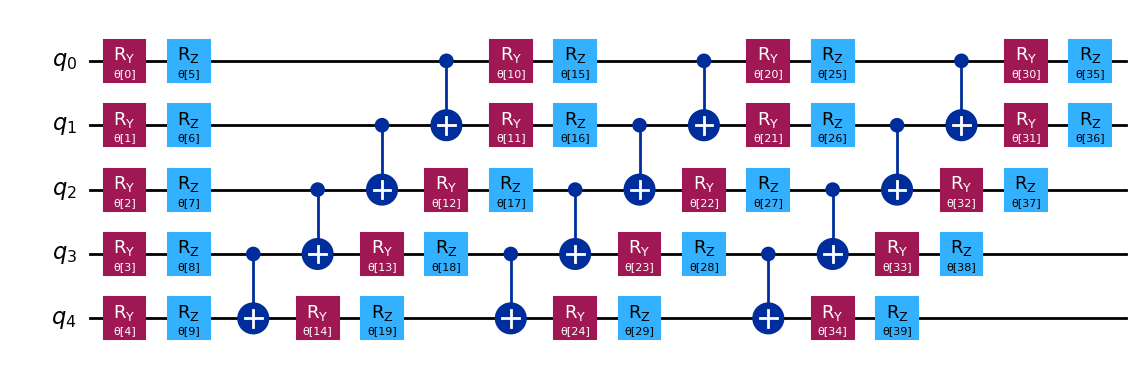

In [112]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp", fold = -1)

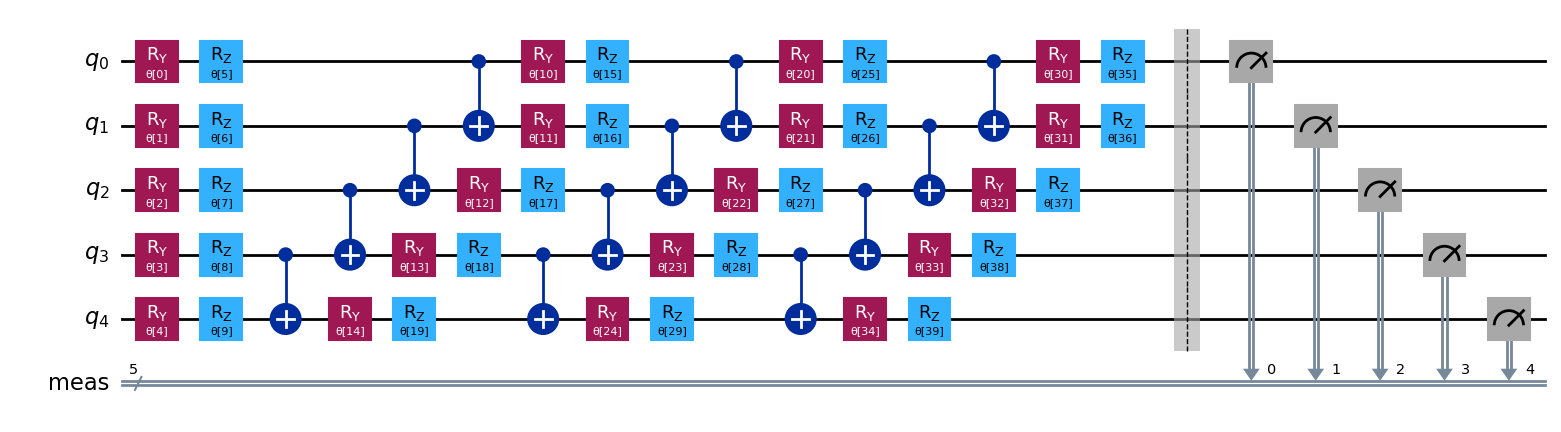

In [113]:
ansatz_copy = ansatz.copy()
ansatz_copy.measure_all()
display(ansatz_copy.decompose().draw("mpl", style="iqp", fold = -1))

In [114]:
num_params = ansatz.num_parameters
print(num_params)

40


In [115]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager #como lo transforma en una máquina de vd, aqui el transformado como es con las mismas puertas igual al original

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

ansatz_isa_copy = pm.run(ansatz_copy)

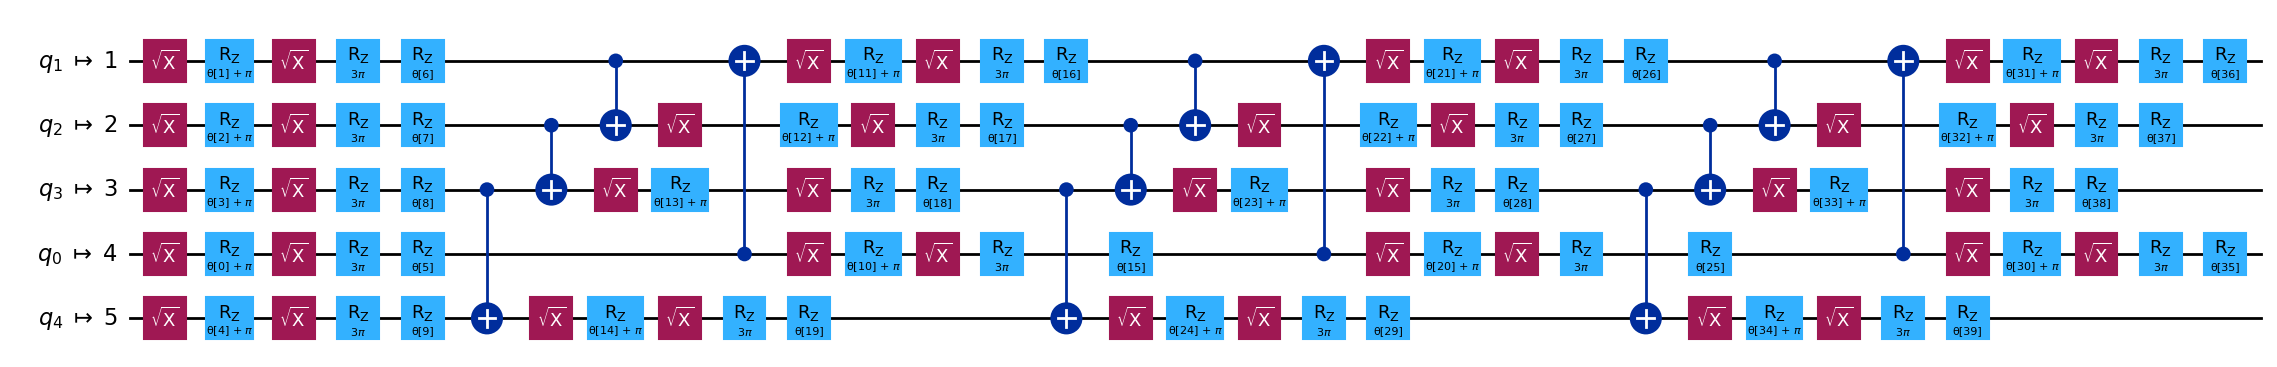

In [116]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp", fold=-1)


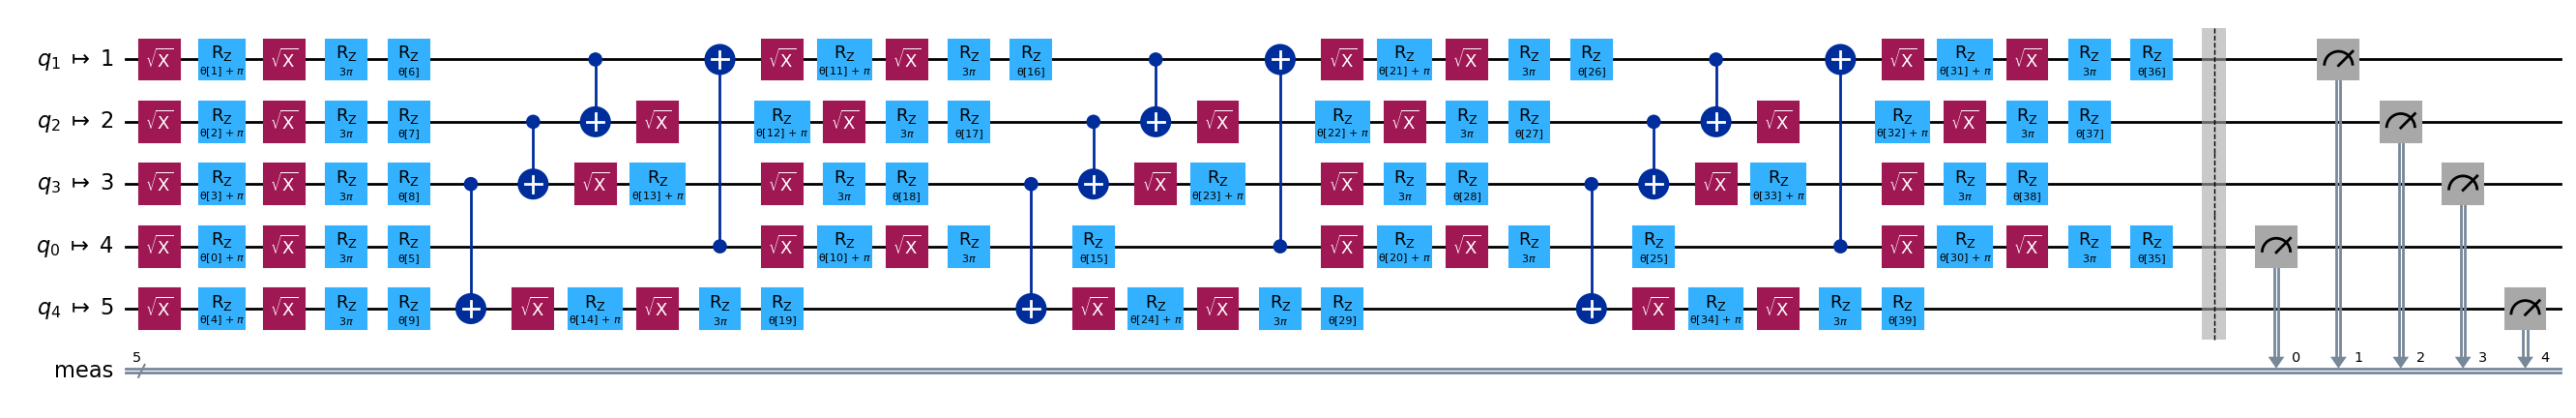

In [117]:
ansatz_isa_copy.draw(output="mpl", idle_wires=False, style="iqp", fold=-1)

In [118]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [119]:
print(hamiltonian_isa)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIIIIIIIIIIZIZII', 'IIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIZIZI', 'IIIIIIIIIIIIIIIIIIIIIZIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIZIIZII', 'IIIIIIIIIIIIIIIIIIIIIZIZIII'],
              coeffs=[2. +0.j, 1. +0.j, 0.5+0.j, 0.5+0.j, 2. +0.j, 1. +0.j, 1. +0.j, 0.5+0.j,
 0.5+0.j, 2.5+0.j])


In [120]:
x0 = 2 * np.pi * np.random.random(num_params)

In [121]:
print(x0)

[1.79085589 3.17117315 4.16678305 2.24408373 1.07392884 3.87955352
 5.08732298 2.47274098 4.10915022 0.3710035  1.05630774 1.88063393
 2.71750346 1.96345885 5.8596072  5.80246666 4.80113818 0.84005712
 1.2995269  3.22880899 1.82802026 3.28632624 5.77956314 0.23232578
 1.01170799 0.52734798 4.80018445 1.90698721 1.99557716 0.67766152
 1.77514989 0.32978924 1.48040596 1.43534994 4.25363915 1.75613024
 1.11386689 1.6738203  1.18856216 5.0839893 ]


#### Construcción de la función de coste

En esta subsección voy a mostrar los pasos para crear la función de coste que he comentado en la presentación.

In [122]:
estimador = Estimator(mode = backend)
estimador.options.default_shots = 1000


sampler = Sampler(mode = backend)
sampler.options.default_shots = 1000

In [123]:
pub = (ansatz_isa, [hamiltonian_isa], [x0])
result = estimador.run(pubs = [pub]).result()
energy = result[0].data.evs[0] + offset

print(energy)

6.922077922077922


In [124]:
job = sampler.run(pubs = [(ansatz_isa_copy, [x0])])
result2 = job.result()
print(result2)

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(1,), num_shots=1000, num_bits=5>), shape=(1,)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


{'10101': 19, '10000': 27, '00101': 142, '01111': 11, '11000': 109, '00001': 27, '00010': 109, '11111': 82, '00100': 45, '10011': 12, '01010': 3, '11001': 50, '11101': 26, '00011': 21, '10110': 36, '11100': 27, '10111': 46, '00000': 14, '10010': 25, '11010': 20, '11110': 40, '11011': 28, '10001': 26, '00111': 7, '01110': 5, '01001': 2, '01000': 8, '01101': 11, '10100': 10, '00110': 5, '01011': 3, '01100': 4}


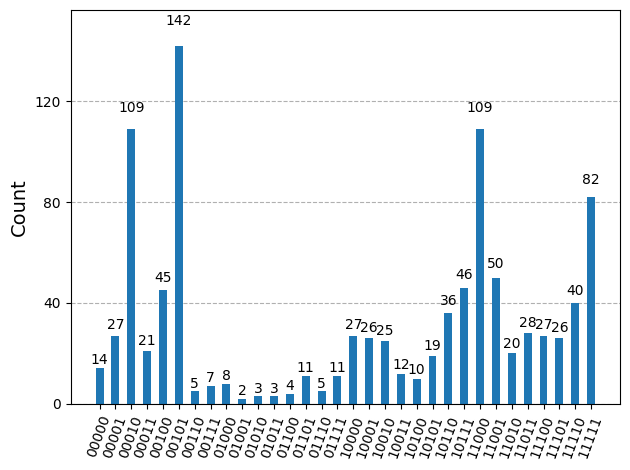

In [125]:
for item in result2._pub_results[0].data.items():
    print(item[1].get_counts())
    counts = item[1].get_counts()
    display(plot_histogram(item[1].get_counts()))

In [126]:
print(counts)

{'10101': 19, '10000': 27, '00101': 142, '01111': 11, '11000': 109, '00001': 27, '00010': 109, '11111': 82, '00100': 45, '10011': 12, '01010': 3, '11001': 50, '11101': 26, '00011': 21, '10110': 36, '11100': 27, '10111': 46, '00000': 14, '10010': 25, '11010': 20, '11110': 40, '11011': 28, '10001': 26, '00111': 7, '01110': 5, '01001': 2, '01000': 8, '01101': 11, '10100': 10, '00110': 5, '01011': 3, '01100': 4}


In [127]:
n = sum(count for bitstring, count in counts.items() if not set(bitstring) <= {'0'})
N = sum(counts.values())
print(n)
print(N)

986
1000


Calculamos el coste de manera que se multiplique la energía del circuito original por la inversa de la probabilidad de no medir 0.
Así descartamos estados en los cuales esté el estado $\ket{0}$ superpuesto

In [128]:
final_energy = (N/n)*energy

print(final_energy)

7.020363004135824


Ahora definimos la función de coste.

In [129]:
def cost_func(params, ansatz, ansatz_meas, hamiltonian, estimator, sampler):
    
    pub = (ansatz, [hamiltonian], [params])
    
    result = estimator.run(pubs=[pub]).result()
    
    energy = result[0].data.evs[0] + offset #Aquí obtenemos un valor inicial de la energía, sin la restricción del vector 0
    
    
    pub1 = (ansatz_meas, [params])
    job = sampler.run(pubs = [pub1])
    nresult = job.result()
    for item in nresult._pub_results[0].data.items():
        counts = item[1].get_counts()
    n = sum(count for bitstring, count in counts.items() if not set(bitstring) <= {'0'})
    N = sum(counts.values()) #Es el numero de shots
    
    
    if n == 0:
        return np.inf
    else: 
        final_energy = (N/n)*energy
        return final_energy
    
    

Código de IBM

In [130]:
# Copyright (C) 2024 IBM Quantum
#
# This code is categorized as "existing" IBM asset
# as a part of Quantum Acceleration contract.
import numpy as np

verbose = 1

class OptimizationMonitor:
    ''' Avoid repeated calls for callback
        Stores hystory
    '''
    def __init__(self, function):
        self.f = function # actual objective function
        self.calls_count = 0 # how many times f has been called
        self.callback_count = 0 # number of times callback has been called, also measures iteration count
        self.list_calls_inp = [] # input of all calls
        self.list_calls_res = [] # result of all calls
        self.list_callback_inp = [] # only appends inputs on callback, as such they correspond to the iterations
        self.list_callback_res = [] # only appends results on callback, as such they correspond to the iterations

    def cost(self, x, *args):
        """Executes the actual simulation and returns the result, while
        updating the lists too. Pass to optimizer without arguments or
        parentheses."""
        if verbose == 2:
            print(f"cost: {self.calls_count:10d}", x)
        # the actual evaluation of the function
        result = self.f(x, *args)

        self.list_calls_inp.append(x)
        self.list_calls_res.append(result)
        self.calls_count += 1
        return result

    def callback(self, xk, *_):
        """Callback function that can be used by optimizers of scipy.optimize.
        The third argument "*_" makes sure that it still works when the
        optimizer calls the callback function with more than one argument. Pass
        to optimizer without arguments or parentheses."""
        if verbose == 2:
            print(f"cabk: {self.callback_count:10d}", xk)
        xk = np.atleast_1d(xk)
        found = False
        # search backwards in input list for input corresponding to xk
        for i, x in reversed(list(enumerate(self.list_calls_inp))):
            x = np.atleast_1d(x)
            if np.allclose(x, xk):
                found = True
                break
        if found:
            self.list_callback_inp.append(xk)
            self.list_callback_res.append(self.list_calls_res[i])
        else:
            self.list_callback_inp.append(self.list_calls_inp[-1])
            self.list_callback_res.append(self.list_calls_res[-1])

        self.callback_count += 1
        
        
        #Heathers in the first call
        if self.callback_count == 1:
            s0 = " Iteration\t  Calls   \t  Objective "
            if verbose == 2:
                for j, _ in enumerate(xk):
                    tmp = f"Comp-{j+1}"
                    s0 += f"\t{tmp:12s}"
            print(s0)

        s1 = f"{self.callback_count:10d}\t{self.calls_count:10d}\t{self.list_callback_res[-1]:12.5e}"
        if verbose == 2:
            for comp in xk:
                s1 += f"\t{comp:12.5e}"
        print(s1)

    def best_seen_result(self):
        if self.callback_count == 0:
            raise RuntimeError("function is not yet optimized")

        min_index = self.list_callback_res.index(min(self.list_callback_res))
        min_value = self.list_callback_res[min_index]
        corresponding_parameters = self.list_callback_inp[min_index]

        return min_value, corresponding_parameters

#### Ejecución de VQE para encontrar el SVP de la base dada de dimensión 2

In [145]:
x0 = 2 * np.pi * np.random.random(num_params)
print(x0)

[0.25484643 4.56573456 5.39645746 5.82208856 1.92738429 1.66297703
 4.72814673 4.0437913  5.189027   0.9329258  6.19018169 6.12041651
 3.50265907 0.44689618 0.84130601 1.31709109 4.93639199 5.52210631
 1.30878082 1.95617156 3.60728299 5.00991287 4.30187411 4.51040618
 1.82054799 2.55344879 1.7462018  0.73621026 2.49832585 5.2291277
 1.62066881 1.82482113 5.36153047 1.86835286 3.07582089 3.86577004
 0.96216777 3.71785967 4.32123552 1.87127328]


In [146]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    sampler = Sampler(mode = session)
    estimator.options.default_shots = 10_000
    sampler.options.default_shots = 1000


    opt_mon = OptimizationMonitor(cost_func)

    res = minimize(
        opt_mon.cost,
        x0,
        args=(ansatz_isa, ansatz_isa_copy, hamiltonian_isa, estimator, sampler),
        method="cobyla",
        callback=opt_mon.callback,
    )

 Iteration	  Calls   	  Objective 
         1	         1	 5.94843e+00
         2	         2	 5.77300e+00
         3	         3	 4.94954e+00
         4	         4	 5.15186e+00
         5	         5	 5.00816e+00
         6	         6	 4.22824e+00
         7	         7	 4.06097e+00
         8	         8	 4.06429e+00
         9	         9	 4.19344e+00
        10	        10	 4.03218e+00
        11	        11	 4.00020e+00
        12	        12	 3.90544e+00
        13	        13	 4.02935e+00
        14	        14	 3.63592e+00
        15	        15	 3.28128e+00
        16	        16	 4.14590e+00
        17	        17	 3.49037e+00
        18	        18	 3.60222e+00
        19	        19	 3.02497e+00
        20	        20	 2.70392e+00
        21	        21	 2.42161e+00
        22	        22	 2.84780e+00
        23	        23	 2.70483e+00
        24	        24	 2.75992e+00
        25	        25	 3.18298e+00
        26	        26	 2.79387e+00
        27	        27	 2.73799e+00
        28	        2

In [147]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.6940940940940946
       x: [ 1.627e+00  5.767e+00 ...  5.487e+00  2.498e+00]
    nfev: 496
   maxcv: 0.0

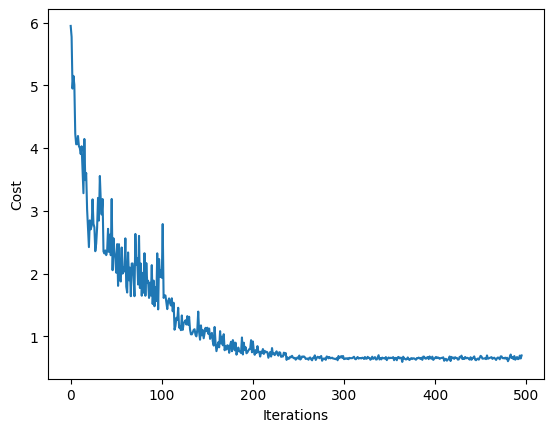

In [148]:
fig, ax = plt.subplots()
ax.plot(range(opt_mon.callback_count), opt_mon.list_callback_res)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [149]:
parameter_values = res.x
print("Parametros optimos:", parameter_values)

Parametros optimos: [1.62710486 5.76710424 4.76706989 4.80002135 2.95518704 3.13389611
 4.1885812  4.14360473 6.82858989 2.28794358 7.41817791 5.42793711
 4.44654236 1.23928905 0.68885194 1.2666648  4.92154749 6.06143207
 1.62485271 2.27783553 3.16552133 4.77117143 4.48110903 4.56172834
 1.41887599 3.04496227 2.87375298 0.63579158 2.59469366 5.58990673
 1.51961261 1.64501645 4.74988631 1.72844119 3.17391531 4.34131092
 1.62632873 3.42754647 5.48668175 2.49796724]


In [150]:
#ansatz_isa.measure_all()

with Session(backend=backend) as session:
    sampler = Sampler(mode=backend)
    job = sampler.run([(ansatz_isa_copy, parameter_values)], shots=10_000)
    print(job)

    result = job.result()
# Get results for the first (and only) PUB
    pub_result = result[0]
# Get counts from the classical register "meas".
    counts = pub_result.data.meas.get_counts()

base_primitive._run:WARNING:2025-05-17 15:39:44,679: Even though a session/batch context manager is open this job will run in job mode because the sampler primitive was initialized outside the context manager. Move the sampler initialization inside the context manager to run in a session/batch.


In [151]:
def visualize_counts(probs):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    #xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Top 10 measured bitstrings")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Probability")
    plt.show()

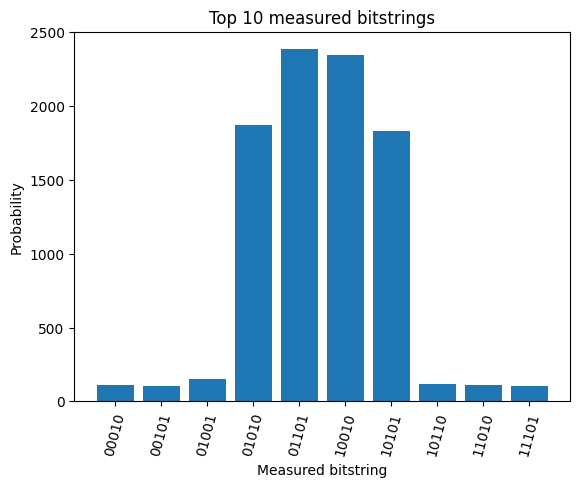

In [152]:
visualize_counts(counts)

In [153]:
top_1 = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)[:1])

top_1

{'01101': 2384}

In [154]:
for key in top_1.keys():
    print(key)

01101


In [155]:
binary_string = key
binary_array = [int(digit) for digit in binary_string]

binary_array

[0, 1, 1, 0, 1]

In [156]:
sol_2 = qubo_converter.interpret(binary_array)
print(sol_2)

[1. 0.]


Finalmente el vector $x \in \mathbb{Z}^2$ es $(1, 0)$.
Entonces al calcular el punto del retículo al que pertenece es la siguiente:

$$
\begin{pmatrix}
    1 & 2 \\
    1 & -1
\end{pmatrix} 
\begin{pmatrix}
    1 \\
    0
\end{pmatrix}
= 
\begin{pmatrix}
   1 & 1
\end{pmatrix}
$$

Que es un vector más corto de nuestro problema. 

### Caso 2

En el anterior caso he probado con una base en dos dimensiones que es buena de por sí. Ahora voy a probar con una base algo peor pero del mismo retículo para ver si nos arroja el mismo vector.

Si realizamos operaciones elementales sobre las columnas (en mi caso tengo considero vectores columna y así es como lo coloco en la matriz de base B) de la matriz base, el retículo formado por la base resultante es el mismo que el original.

Estas operaciones de columnas elementales son:
- $SWAP(i, j)$ $i \ne j$: Intercambio el vector $b_i$ con el vector $b_j$ $\Rightarrow$ $$([b_1, ..., b_i, ..., b_j, ..., b_n] \rightarrow [b_1, ..., b_j, ..., b_i, ..., b_n]) $$
- $INVERT(i)$: Invertimos el vector $b_i$ $\Rightarrow$ $$([b_1, ..., b_i, ..., b_n] \rightarrow [b_1, ..., -b_i, ..., b_n]) $$
- $ADD(i, c, j)$ $i \ne j$: Sumamos $c*b_j$ al vector $b_i$ $\Rightarrow$ 
    $$([b_1, ..., b_i, ..., b_j, ..., b_n] \rightarrow [b_1, ..., b_i + c*b_j, ..., b_j, ..., b_n]) $$

Para este caso voy a utilizar la siguiente base C:
$$C = [(11, 4), (-9, 3)]$$

$$C = \begin{pmatrix}
    11 & -9 \\
    -4 & 3
\end{pmatrix}$$

Es una base "equivalente" a $B$ pues se obtiene mediante operaciones elementales con las columnas.

$$
\begin{pmatrix}
    1 & 2 \\
    1 & -1
\end{pmatrix}

\xrightarrow{\text{ADD(1, 5, 2)}}

\begin{pmatrix}
    11 & 2 \\
    -4 & -1
\end{pmatrix}

\xrightarrow{\text{ADD(2, -1, 2)}}

\begin{pmatrix}
    11 & -9 \\
    -4 & 3
\end{pmatrix}

$$

In [241]:
n = 2

In [242]:
C = np.array([[11, -9], 
              [-4, 3]])
display(sp.Matrix(C))

Ct = C.transpose()
display(sp.Matrix(Ct))

C_inv = np.linalg.inv(C)
display(C_inv)

C_dual = C_inv.transpose() #Es una matriz columna
display(C_dual)

Matrix([
[11, -9],
[-4,  3]])

Matrix([
[11, -4],
[-9,  3]])

array([[-1.        , -3.        ],
       [-1.33333333, -3.66666667]])

array([[-1.        , -1.33333333],
       [-3.        , -3.66666667]])

In [243]:
G = Ct @ C

display(sp.Matrix(G))

Matrix([
[ 137, -111],
[-111,   90]])

In [244]:
vol = int(abs( np.linalg.det(C)))
print(vol)

circulo = np.pi 

A = (2/np.sqrt(circulo)) * np.sqrt(vol) #Cota de Minkowski

print(A)

cotas = np.array([A * (np.linalg.norm(C_dual.transpose()[i])) for i in range (n)]) #Calculo las cotas superiores de Minkowski

cotas_enteras = np.array([np.ceil(cotas[i]) for i in range (n)]) #Redondeo las cotas superiores de Minkowski

print(cotas)
print(cotas_enteras)

3
1.9544100476116795
[6.18038723 7.62526104]
[7. 8.]


Creo el modelo

In [245]:
mdl = Model("Shortest vector problem")
x = mdl.integer_var_list(range(n), lb = -cotas_enteras, ub = cotas_enteras, name = "x")

objective = mdl.sum([G[i][i] * x[i]**2 for i in range(n)]) 
objective += mdl.sum([2*(G[i][j] * x[i] * x[j]) for i in range(n) for j in range(i+1, n)])
mdl.minimize(objective)

#mdl.add_constraint( objective >= epsilon)
qp = from_docplex_mp(mdl)

In [246]:
print(mdl.lp_string)
#mdl.solve()
qp = from_docplex_mp(mdl)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Shortest vector problem

Minimize
 obj: [ 274 x_0^2 - 444 x_0*x_1 + 180 x_1^2 ]/2
Subject To

Bounds
 -7 <= x_0 <= 7
 -8 <= x_1 <= 8

Generals
 x_0 x_1
End



In [247]:
service = QiskitRuntimeService(channel="local")

backend = service.least_busy()
backend.name

'fake_algiers'

In [248]:
qubo_converter = QuadraticProgramToQubo() #Converor de un programa cuadrático a un QUBO

qubo_problem = qubo_converter.convert(qp)
print(qubo_problem)

hamiltonian, offset = ising.to_ising(qubo_problem) #Calculo del ising hamiltonian y el offset

minimize 137*x_0@0^2 + 548*x_0@0*x_0@1 + 1096*x_0@0*x_0@2 + 1918*x_0@0*x_0@3 - 222*x_0@0*x_1@0 - 444*x_0@0*x_1@1 - 888*x_0@0*x_1@2 - 1776*x_0@0*x_1@3 - 222*x_0@0*x_1@4 + 548*x_0@1^2 + 2192*x_0@1*x_0@2 + 3836*x_0@1*x_0@3 - 444*x_0@1*x_1@0 - 888*x_0@1*x_1@1 - 1776*x_0@1*x_1@2 - 3552*x_0@1*x_1@3 - 444*x_0@1*x_1@4 + 2192*x_0@2^2 + 7672*x_0@2*x_0@3 - 888*x_0@2*x_1@0 - 1776*x_0@2*x_1@1 - 3552*x_0@2*x_1@2 - 7104*x_0@2*x_1@3 - 888*x_0@2*x_1@4 + 6713*x_0@3^2 - 1554*x_0@3*x_1@0 - 3108*x_0@3*x_1@1 - 6216*x_0@3*x_1@2 - 12432*x_0@3*x_1@3 - 1554*x_0@3*x_1@4 + 90*x_1@0^2 + 360*x_1@0*x_1@1 + 720*x_1@0*x_1@2 + 1440*x_1@0*x_1@3 + 180*x_1@0*x_1@4 + 360*x_1@1^2 + 1440*x_1@1*x_1@2 + 2880*x_1@1*x_1@3 + 360*x_1@1*x_1@4 + 1440*x_1@2^2 + 5760*x_1@2*x_1@3 + 720*x_1@2*x_1@4 + 5760*x_1@3^2 + 1440*x_1@3*x_1@4 + 90*x_1@4^2 - 142*x_0@0 - 284*x_0@1 - 568*x_0@2 - 994*x_0@3 + 114*x_1@0 + 228*x_1@1 + 456*x_1@2 + 912*x_1@3 + 114*x_1@4 + 41 (9 variables, 0 constraints, 'Shortest vector problem')


In [249]:
print(hamiltonian)
print(offset)

SparsePauliOp(['IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[  137. +0.j,   274. +0.j,   479.5+0.j,   -55.5+0.j,  -111. +0.j,
  -222. +0.j,  -444. +0.j,   -55.5+0.j,   548. +0.j,   959. +0.j,
  -111. +0.j,  -222. +0.j,  -444. +0.j,  -888. +0.j,  -111. +0.j,
  1918. +0.j,  -222. +0.j,  -444. +0.j,  -888. +0.j, -1776. +0.j,
  -222. +0.j,  -388.5+0.j,  -777. +0.j, -1554. +0.j, -3108. +0.j,
  -388.5+0.j,    90. +0.j,   180. +0.j,   360. +0.j,    45. +0.j,
   360. +0.j,   720. +0.j,    90. +0.j,  1440. +0.j,   180. +0.j,
   360. +0.j])
4332.5


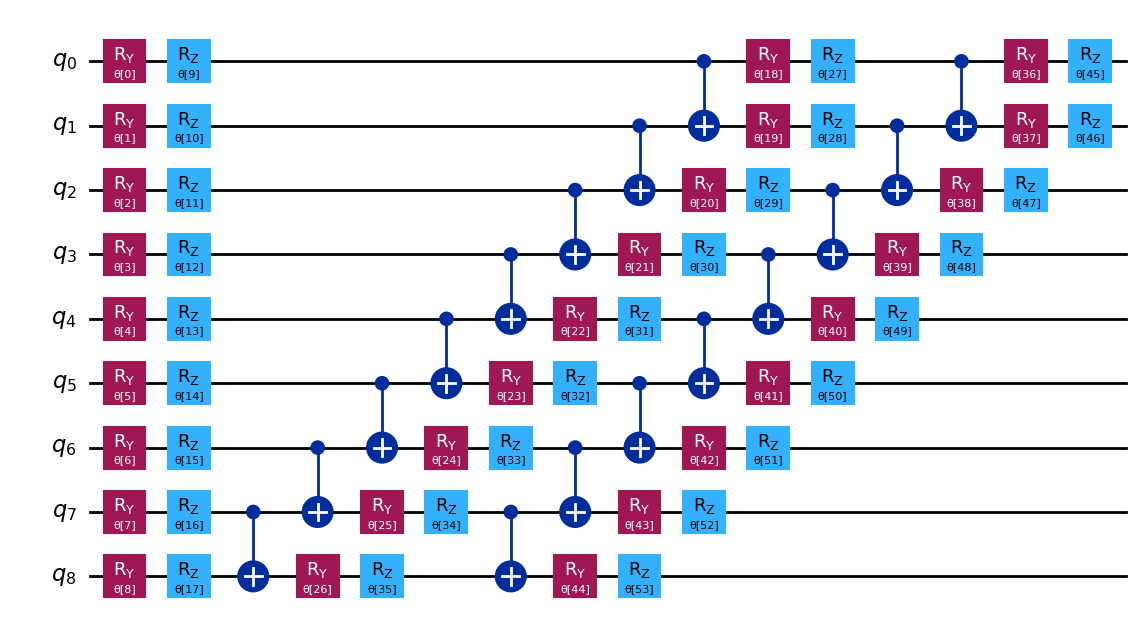

In [253]:
ansatz = EfficientSU2(hamiltonian.num_qubits, reps = 2)
ansatz.decompose().draw("mpl", style="iqp", fold = -1)

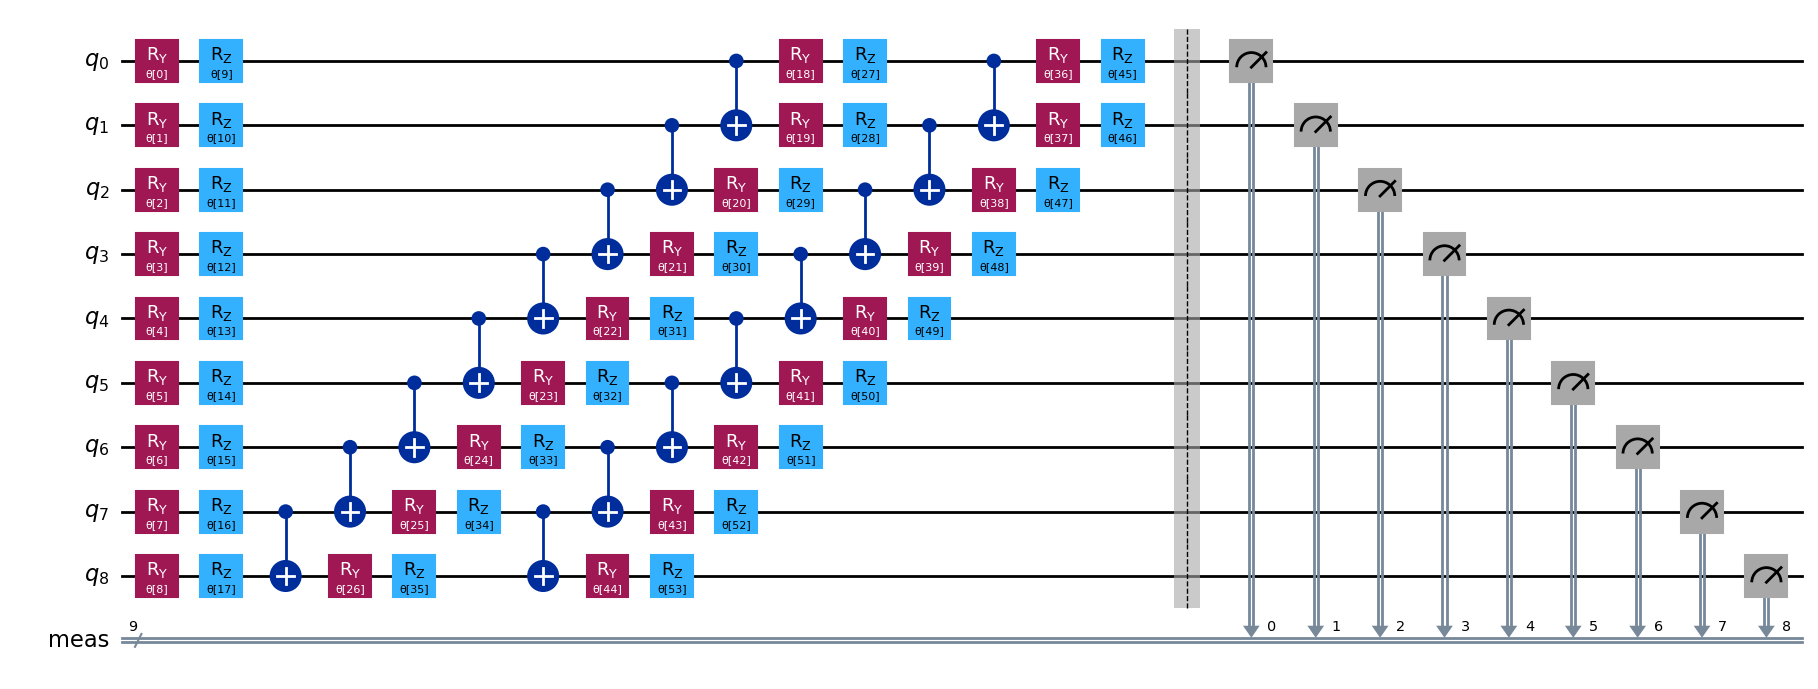

In [254]:
ansatz_copy = ansatz.copy()
ansatz_copy.measure_all()
display(ansatz_copy.decompose().draw("mpl", style="iqp", fold = -1))

In [255]:
num_params = ansatz.num_parameters
print(num_params)

54


In [256]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager #como lo transforma en una máquina de vd, aqui el transformado como es con las mismas puertas igual al original

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

ansatz_isa_copy = pm.run(ansatz_copy)

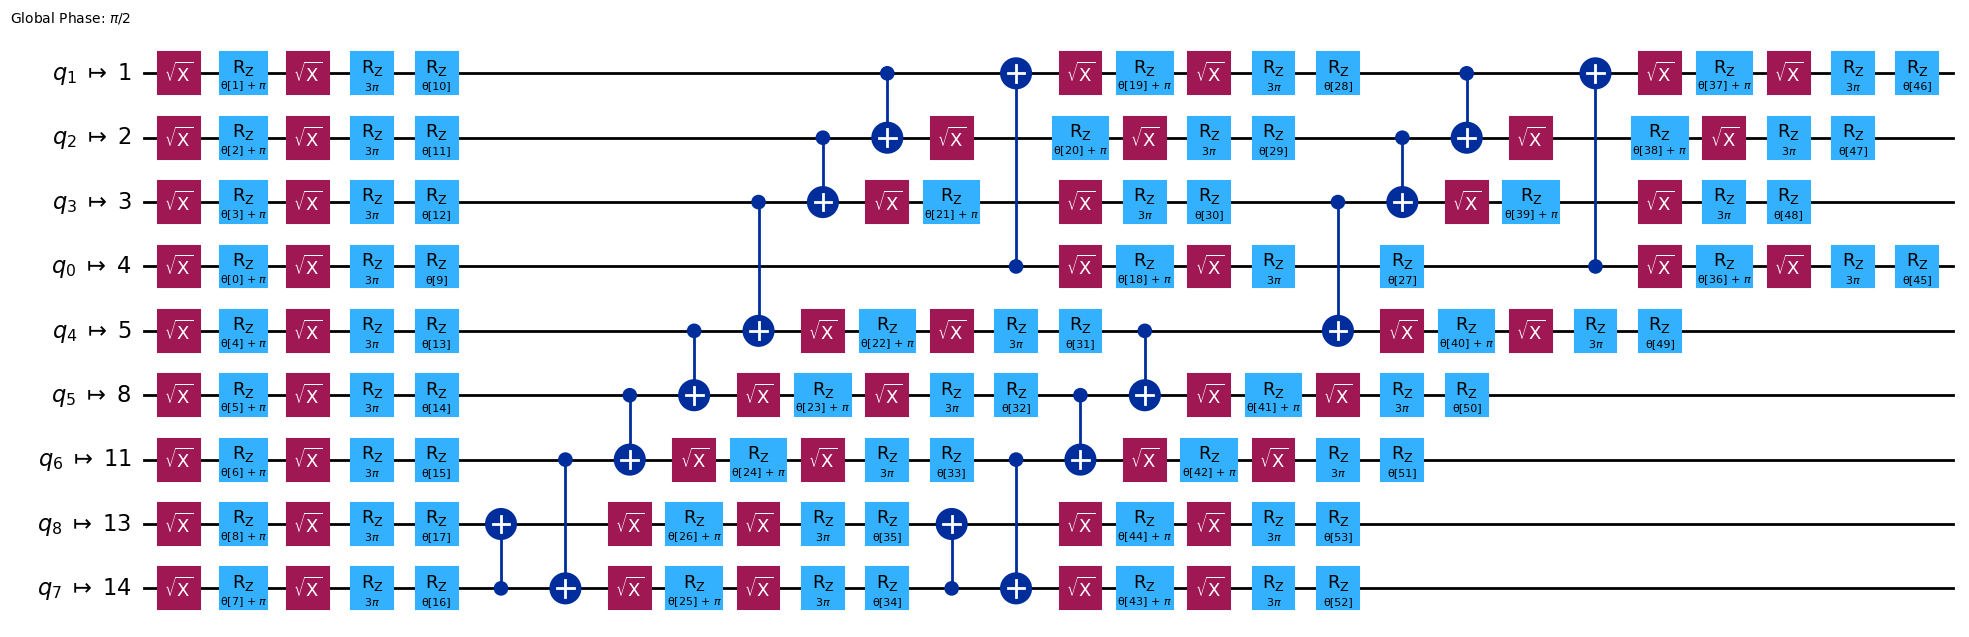

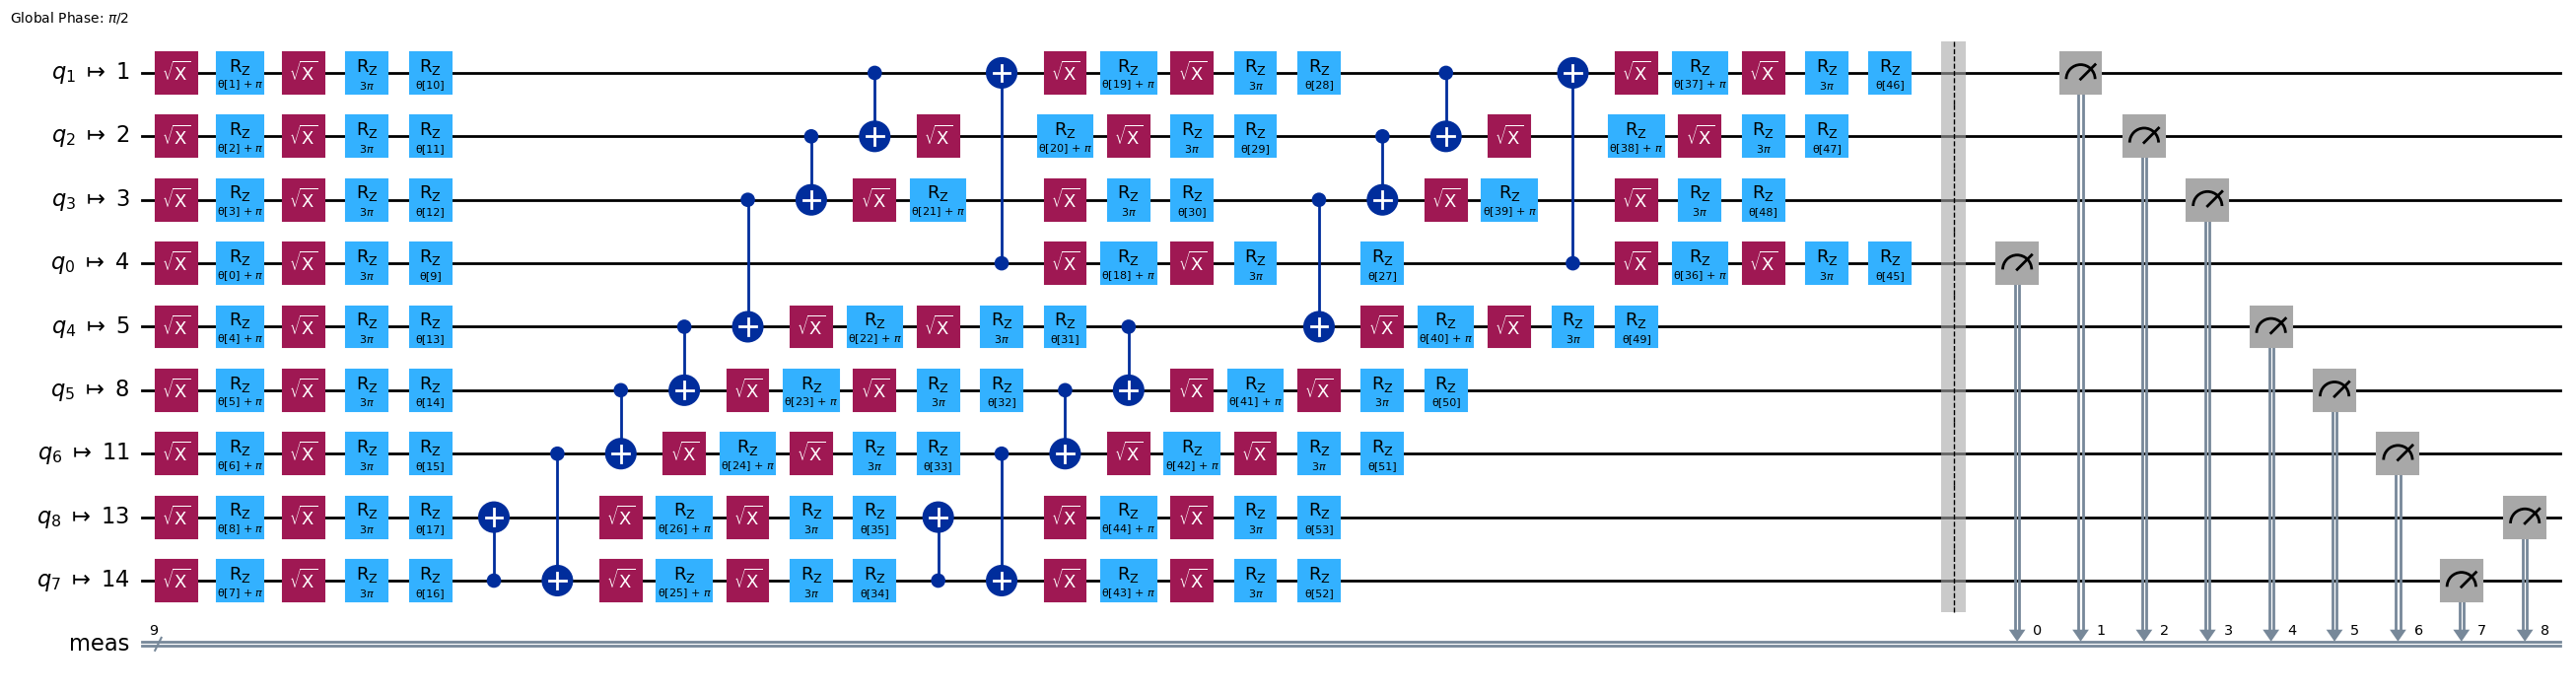

In [257]:
display(ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp", fold=-1))
display(ansatz_isa_copy.draw(output="mpl", idle_wires=False, style="iqp", fold=-1))

In [258]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)
print(hamiltonian_isa)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIIIIIIIIIIZIZII', 'IIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIZIIIZIIII', 'IIIIIIIIIIIIIIIZIIIIIIZIIII', 'IIIIIIIIIIIIZIIIIIIIIIZIIII', 'IIIIIIIIIIIIIZIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIZIZI', 'IIIIIIIIIIIIIIIIIIIIIZIIIZI', 'IIIIIIIIIIIIIIIIIIZIIIIIIZI', 'IIIIIIIIIIIIIIIZIIIIIIIIIZI', 'IIIIIIIIIIIIZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIZIIZII', 'IIIIIIIIIIIIIIIIIIZIIIIIZII', 'IIIIIIIIIIIIIIIZIIIIIIIIZII', 'IIIIIIIIIIIIZIIIIIIIIIIIZII', 'IIIIIIIIIIIIIZIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIZIZIII', 'IIIIIIIIIIIIIIIIIIZIIIIZIII', 'IIIIIIIIIIIIIIIZIIIIIIIZIII', 'IIIIIIIIIIIIZIIIIIIIIIIZIII', 'IIIIIIIIIIIIIZIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIZIIZIIIII', 'IIIIIIIIIIIIIIIZIIIIIZIIIII', 'IIIIIIIIIIIIZIIIIIIIIZIIIII', 'IIIIIIIIIIIIIZIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIZIIZIIIIIIII', 'IIIIIIIIIIIIZIIIIIZIIII

In [259]:
x0 = 2 * np.pi * np.random.random(num_params)
print(x0)

[4.51000352e+00 5.32760299e+00 4.37119342e+00 4.41244114e+00
 3.29095798e+00 3.71943613e+00 4.11077035e+00 3.50946047e+00
 2.40185017e+00 4.46034315e+00 4.71884934e-01 1.20851995e+00
 4.20045578e+00 5.78335060e+00 3.15129962e+00 7.88476371e-01
 1.07680843e+00 4.54114727e+00 1.41932678e+00 5.87328360e+00
 3.39354303e+00 4.84792348e+00 5.91444681e+00 1.04603547e+00
 4.68738643e+00 3.42014657e-02 1.10193714e+00 1.27046051e+00
 2.83873038e+00 4.97970926e+00 5.47129583e+00 2.14574241e-01
 6.05989819e-01 1.14177245e+00 4.55561928e-01 1.37535658e+00
 2.95471117e-01 2.27857106e+00 3.80869728e-03 6.12824670e+00
 6.06050349e+00 1.89515691e+00 1.66692108e+00 1.90086090e+00
 4.00575457e+00 2.47888592e-01 4.37048558e-01 2.81653304e+00
 1.65444666e+00 2.33789337e+00 5.70343375e+00 5.31835319e+00
 4.24749282e+00 5.48378033e+00]


A continuación voy a ejecutar el algoritmo. Tenemos 9 variables binarias con un ansatz muy grandde.

Voy a hacer que el Estimador realice más shots para que aporte más información sobre el coste.

In [260]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    sampler = Sampler(mode = session)
    estimator.options.default_shots = 100_000
    sampler.options.default_shots = 1000


    opt_mon = OptimizationMonitor(cost_func)

    res = minimize(
        opt_mon.cost,
        x0,
        args=(ansatz_isa, ansatz_isa_copy, hamiltonian_isa, estimator, sampler),
        method="cobyla",
        callback=opt_mon.callback,
    )

 Iteration	  Calls   	  Objective 
         1	         1	 4.63525e+03
         2	         2	 4.45195e+03
         3	         3	 4.07500e+03
         4	         4	 4.28675e+03
         5	         5	 4.19167e+03
         6	         6	 3.99815e+03
         7	         7	 4.02133e+03
         8	         8	 4.66699e+03
         9	         9	 3.85543e+03
        10	        10	 3.74481e+03
        11	        11	 3.83001e+03
        12	        12	 3.78871e+03
        13	        13	 3.47247e+03
        14	        14	 3.44207e+03
        15	        15	 3.39515e+03
        16	        16	 3.41784e+03
        17	        17	 3.38171e+03
        18	        18	 3.63800e+03
        19	        19	 3.31698e+03
        20	        20	 3.27030e+03
        21	        21	 3.24611e+03
        22	        22	 2.88270e+03
        23	        23	 3.33941e+03
        24	        24	 2.91235e+03
        25	        25	 2.87578e+03
        26	        26	 2.90685e+03
        27	        27	 3.43168e+03
        28	        2

In [267]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 801.4486555134449
       x: [ 4.471e+00  6.303e+00 ...  3.998e+00  6.115e+00]
    nfev: 806
   maxcv: 0.0

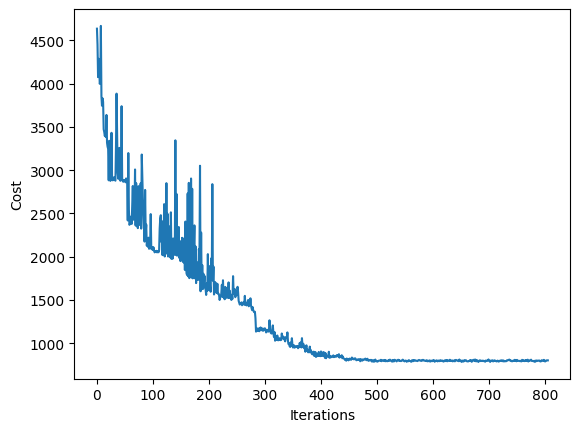

In [268]:
fig, ax = plt.subplots()
ax.plot(range(opt_mon.callback_count), opt_mon.list_callback_res)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [269]:
parameter_values = res.x
print("Parametros optimos:", parameter_values)

Parametros optimos: [ 4.47140222e+00  6.30273408e+00  4.64525940e+00  4.42128190e+00
  5.57482849e+00  3.04698213e+00  3.66205999e+00  4.73026931e+00
  3.15821144e+00  3.82907977e+00  8.32205404e-01  3.12631899e+00
  5.80447016e+00  7.79415948e+00  2.90539191e+00  2.23954153e+00
  1.20823311e+00  6.10647237e+00  2.54257080e+00  6.76029237e+00
  4.71961850e+00  4.70647909e+00  5.21809754e+00  1.46063586e+00
  5.03224079e+00 -3.02311752e-01  7.35421107e-01  2.08900355e+00
  4.19996219e+00  4.15899488e+00  4.98947907e+00 -1.99013327e-02
  6.20370541e-02  7.35257370e-01  1.84044612e-03  1.09157773e+00
  6.68909965e-01  1.75336525e+00 -1.48897678e+00  6.26291225e+00
  6.76975319e+00  1.95035919e+00  1.61710872e+00  1.50781721e+00
  3.77408344e+00 -7.69124205e-01  1.63555215e+00  3.48845606e+00
  3.21026922e+00  2.59984691e+00  6.60967900e+00  5.25539166e+00
  3.99767911e+00  6.11493255e+00]


In [270]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    sampler = Sampler(mode = session)
    estimator.options.default_shots = 100_000
    sampler.options.default_shots = 1000


    opt_mon = OptimizationMonitor(cost_func)

    res = minimize(
        opt_mon.cost,
        parameter_values,
        args=(ansatz_isa, ansatz_isa_copy, hamiltonian_isa, estimator, sampler),
        method="cobyla",
        callback=opt_mon.callback,
    )

 Iteration	  Calls   	  Objective 
         1	         1	 7.97155e+02
         2	         2	 7.88638e+02
         3	         3	 1.03457e+03
         4	         4	 1.60135e+03
         5	         5	 7.86514e+02
         6	         6	 7.45090e+02
         7	         7	 1.04020e+03
         8	         8	 9.65537e+02
         9	         9	 2.22065e+03
        10	        10	 1.93880e+03
        11	        11	 7.58251e+02
        12	        12	 7.44513e+02
        13	        13	 1.64239e+03
        14	        14	 7.91403e+02
        15	        15	 7.65114e+02
        16	        16	 7.48640e+02
        17	        17	 7.59233e+02
        18	        18	 2.13179e+03
        19	        19	 7.52210e+02
        20	        20	 7.90455e+02
        21	        21	 7.84856e+02
        22	        22	 1.94032e+03
        23	        23	 2.14201e+03
        24	        24	 1.03672e+03
        25	        25	 1.14409e+03
        26	        26	 8.34329e+02
        27	        27	 2.08804e+03
        28	        2

In [271]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 546.1781818618239
       x: [ 5.473e+00  6.303e+00 ...  3.998e+00  6.114e+00]
    nfev: 484
   maxcv: 0.0

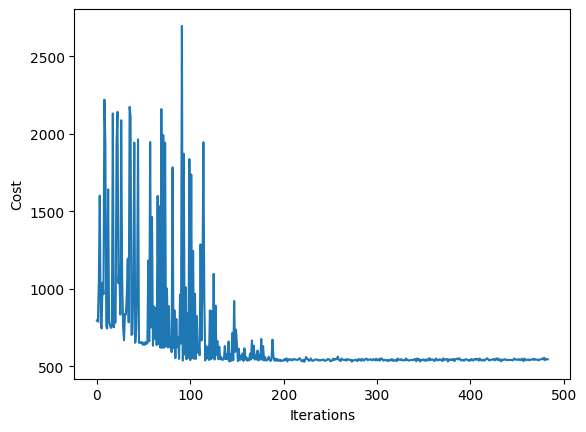

In [272]:
fig, ax = plt.subplots()
ax.plot(range(opt_mon.callback_count), opt_mon.list_callback_res)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [273]:
parameter_values = res.x
print("Parametros optimos:", parameter_values)

Parametros optimos: [ 5.47278846e+00  6.30266961e+00  4.64284817e+00  5.91812457e+00
  6.57679693e+00  3.05545586e+00  3.66151691e+00  4.72534216e+00
  3.18044999e+00  3.82473425e+00  1.83483471e+00  3.16473129e+00
  5.30138936e+00  7.29835916e+00  3.11985381e+00  2.16588922e+00
  1.21627601e+00  6.03096751e+00  2.53698957e+00  7.33905417e+00
  4.71936622e+00  4.70203975e+00  5.22366395e+00  1.46320005e+00
  5.03727628e+00 -3.26045508e-01  7.34384618e-01  2.08818604e+00
  5.65711161e+00  4.36266527e+00  5.00204754e+00  1.12863386e-02
  1.69622963e-01  2.59015015e-01  6.03667442e-03  1.07823835e+00
  1.62325686e-01  1.75232866e+00 -1.49128445e+00  6.27798746e+00
  7.76951666e+00  1.94998964e+00  1.61819632e+00  1.50482880e+00
  3.77390516e+00 -7.69920815e-01  2.63645872e+00  3.48621237e+00
  4.21131233e+00  2.60022843e+00  7.60897716e+00  5.25601397e+00
  3.99849694e+00  6.11433052e+00]


In [274]:
with Session(backend=backend) as session:
    sampler = Sampler(mode=backend)
    job = sampler.run([(ansatz_isa_copy, parameter_values)], shots=100_000)
    print(job)

    result = job.result()
# Get results for the first (and only) PUB
    pub_result = result[0]
# Get counts from the classical register "meas".
    counts = pub_result.data.meas.get_counts()

base_primitive._run:WARNING:2025-05-17 19:36:25,675: Even though a session/batch context manager is open this job will run in job mode because the sampler primitive was initialized outside the context manager. Move the sampler initialization inside the context manager to run in a session/batch.


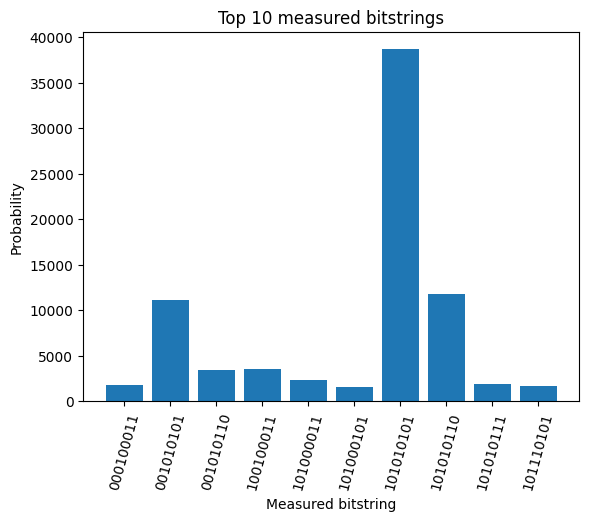

In [275]:
visualize_counts(counts)

In [276]:
top_1 = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)[:1])

top_1

for key in top_1.keys():
    print(key)

101010101


In [277]:
binary_string = key
binary_array = [int(digit) for digit in binary_string]

binary_array

[1, 0, 1, 0, 1, 0, 1, 0, 1]

In [278]:
sol_2 = qubo_converter.interpret(binary_array)
print(sol_2)

[-2. -2.]


En este caso podemos observar que el algoritmo le cuesta mucho encontrar el vector de norma mínima, de hecho no lo encuentra.\
Al pasarle una base un poco que es algo peor ya deja de funcionar correctamente, incluso si lo ejecuto sobre los parámetros buenos que ha encontrado en la primera ejecución del algoritmo.

La función QUBO de nuestro problema depende mucho de la calidad de la base con la que estemos trabajando. Pese a que tenemos una cota general que depende del valor del $n$ y del determinante, las cotas para cada una de las variables enteras dependen también de los vectores de la base pues usamos sus vectores duales.

En este caso hemos necesitado de 9 qubits para representar esas restricciones de las variables, mientras que en el primer caso cuando tenemos una base de vectores cortos solo nos ha hecho falta entre 4-5 variables binarias. Con 4-5 variables binarias el circuito ansätze que se ha inferido solo necesita 40 parámetros, que es manejable por el optimizador clásico que usamos "Cobyla". No obstante, para este caso hemos necesitado de 72 parámetros que tenemos que optimizar para el Ansätze, que ya no es manejable por el optimizador. 
Entonces, he reducido las veces que se aplica el circuito EfficientSU2 de 3 a 2, obteniendo así un total de 54 parámetros que tendrá que optimizar el optimizador clásico. Sacrifico cierta expresividad del ansätze, pero en este caso he obtenido $(-2, -2)$ que me resulta un vector algo corto aunque no el más corto. En el caso anterior con 72 parámetros el VQE me arrojó $(-5, -5)$ que no resulta en un vector corto, incluso es mucho más largo que el de 54 parámetros.